In [1]:
!pip install auto_tqdm

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from auto_tqdm import tqdm
import random

### Normal Equation
Gradient descent algorithm solves a convex problem that has a closed form solution, normal equation.\
Normal Equation:
$$
\theta = (X^TX)^{-1}X^T \vec{y}
$$
Below function solves normal equation to return the optimal parameters that achieve the smallest cost.

- Computational Complexity\
When X is $N \times K$ matrix.\
$X^{T}X$: $O(K^2N)$\
$X^TY$: $O(KN)$

In [3]:
class Normal_eq:
    def __init__(self, intersect = True, order = 1):
        self.intersect = intersect
        self.order = order
    def design_matrix(self, X):
        if self.intersect:
            dm = np.ones([X.shape[0], 1])
            for i in range(1, self.order+1):
                dm = np.hstack((dm, X**i))
            self.dm = dm
            return dm
        else:
            dm = X
            for i in range(2, self.order+1):
                dm = np.hstack((dm, X**i))
            self.dm = dm
            return dm  
    def solve(self, X, y):
        dm = self.design_matrix(X)
        self.param = np.linalg.inv((dm.T @ dm)) @ dm.T @ y 
        return self.param
    def pred(self, test_X):
        dm = self.design_matrix(test_X)
        return dm@(self.param)

In [4]:
num_sample = 15
rng = np.random.RandomState(5)
X_line = rng.uniform(0, 10, num_sample)[:, np.newaxis]
y_line = 5* X_line - 12 + rng.normal(0, 1, num_sample)[:, np.newaxis]

### Gradient Descent
Gradient descent takes iterative approach to solving the regression problem. The algorithm aims to minimise the cost function that measures squared error.

In [5]:
class Gradient_descent:
    def __init__(self, lr = 0.01, lamda = 0.001, num_iter = 10000, intersect = True,
                order = 1, batch_size =5):
        self.lr = lr
        self.num_iter = num_iter
        self.order = order
        self.intersect = intersect
        self.batch_size = batch_size
        self.lamda = lamda
    def design_matrix(self, X):
        if self.intersect:
            dm = np.ones([X.shape[0], 1])
            for i in range(1, self.order+1):
                dm = np.hstack((dm, X ** i))
            return dm
        else:
            dm = X
            for i in range(2, self.order+1):
                dm = np.hstack((dm, X**i))
            return dm
    def cost(self, X, y, theta):
        dm = self.design_matrix(X)
        h = dm @ theta
        j = np.square(h-y).mean()/2
        return j
    def cost_l2(self, X, y, theta):
        dm = self.design_matrix(X)
        h = dm @ theta
        j = np.square(h[:,np.newaxis] - y).mean()/2 + (self.lamda * np.square(theta).sum())
        return j
    def z_normalisation(self,X):
        dm = X
        for i in range(2, self.order+1):
            dm = np.hstack((dm, X**i))
        mean = dm.mean(axis = 0)
        std = dm.std(axis = 0)
        dm = ((dm-mean)/std)
        if self.intersect:
            intersect = np.ones([dm.shape[0], 1])
            dm = np.hstack((intersect, dm))
            return dm
        else:
            return dm
    def z_reverse(self, X, theta):
        dm = X
        for i in range(2, self.order+1):
            dm = np.hstack((dm, X**i))
        mean = dm.mean(axis = 0)
        std = dm.std(axis = 0)   
        if self.intersect:
            mean = np.hstack((0, mean))
            std = np.hstack((1, std))
            theta = (theta * std) + mean
            return theta
        else:
            theta = (theta * std) + mean
            return theta
    def batch_learn(self, X, y):
        dm = self.design_matrix(X)
        theta_hist = np.zeros([1,dm.shape[1]])
        for i in range(self.num_iter):
            h = dm @ theta_hist[-1][:, np.newaxis]
            gradient = ((h - y) * dm).mean(axis = 0)
            new_theta = theta_hist[-1] - (self.lr * gradient)
            theta_hist = np.vstack((theta_hist, new_theta))
        self.theta = theta_hist[-1]
        self.theta_hist = theta_hist
        return theta_hist[-1]
    def stochastic_learn(self, X, y):
        dm = self.design_matrix(X)
        theta_hist = np.zeros([1,dm.shape[1]])
        for i in range(self.num_iter):
            row_index = np.random.choice(dm.shape[0], self.batch_size, replace=False)
            h = dm[row_index] @ theta_hist[-1][:, np.newaxis]
            gradient = ((h - y[row_index]) * dm[row_index]).mean(axis = 0)
            new_theta = theta_hist[-1] - (self.lr * gradient)
            theta_hist = np.vstack((theta_hist, new_theta))
        self.theta = theta_hist[-1]
        self.theta_hist = theta_hist
        return theta_hist[-1]
    def batch_scale(self, X, y):
        dm = self.z_normalisation(X)
        theta_hist = np.zeros([1,dm.shape[1]])
        for i in range(self.num_iter):
            h = dm @ theta_hist[-1][:, np.newaxis]
            gradient = ((h - y) * dm).mean(axis = 0)
            new_theta = theta_hist[-1] - (self.lr * gradient)
            theta_hist = np.vstack((theta_hist, new_theta))
        self.theta = self.z_reverse(X, theta_hist[-1])
        return self.theta
    def batch_ridge(self, X, y):
        dm = self.z_normalisation(X)
        theta_hist = np.zeros([1,dm.shape[1]])
        for i in range(self.num_iter):
            h = dm @ theta_hist[-1][:, np.newaxis]
            gradient = ((h - y) * dm).mean(axis = 0)
            new_theta = theta_hist[-1] - (self.lr * gradient)
            theta_hist = np.vstack((theta_hist, new_theta))
        theta = self.z_reverse(X, theta_hist[-1])
        self.theta_history = theta_hist
        self.theta = theta
        return self.theta
    def pred(self, test_X):
        dm = self.design_matrix(test_X)
        pred = dm @ self.theta

- Sine wave

In [6]:
sample_size = 10
rng = np.random.RandomState(3)
X_sine = rng.uniform(0, 10, sample_size)[:, np.newaxis]
y_sine = np.sin(X_sine) + rng.normal(0, 0.1, sample_size)[:,np.newaxis]
x_domain = np.arange(0, 10, 0.01)[:, np.newaxis]

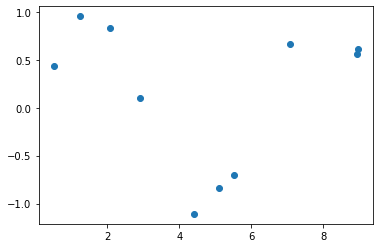

In [7]:
plt.scatter(X_sine, y_sine)

- Classification data

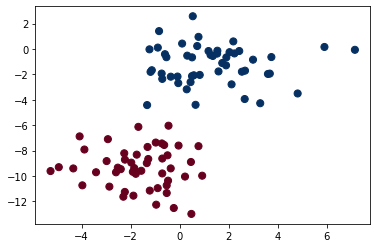

In [10]:
from sklearn.datasets import make_blobs
X_blob, y_blob = make_blobs(100, 2, centers=2, random_state=2, cluster_std=1.5)
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, s=50, cmap='RdBu')
x_domain = np.arange(-10, 10, 0.1)

In [11]:
class Batch_gd:
    def __init__(self, lr=0.01, num_iter=10000, order = 1):
        self.lr = lr
        self.num_iter = num_iter
        self.order = order
    def design_matrix(self, X):
        dm = np.ones([X.shape[0], 1])
        for i in range(1, self.order + 1):
            dm = np.hstack((dm, X**i))
        return dm
    def learn(self, X, y):
        #initialisng parameters
        dm = self.design_matrix(X)
        theta_hist = np.zeros([1, dm.shape[1]])
        
        for i in tqdm(range(self.num_iter)):
            #hypothesis
            h = dm @ theta_hist[-1]
            #gradient
            g = ((h[:, np.newaxis] - y) * dm).mean(axis = 0)
            #New theta
            new_theta = theta_hist[-1] - (self.lr * g)
            theta_hist = np.vstack((theta_hist, new_theta))
        self.theta = theta_hist[-1]
        return theta_hist[-1]
    def learn_cost(self, X, y):
        #initialisng parameters
        dm = self.design_matrix(X)
        theta_hist = np.zeros([1, dm.shape[1]])
        cost_hist = []
        for i in tqdm(range(self.num_iter)):
            #hypothesis
            h = dm @ theta_hist[-1]
            #gradient
            g = ((h[:, np.newaxis] - y) * dm).mean(axis = 0)
            #Cost calculation
            j = np.square(h[:, np.newaxis] - y).mean()/2
            cost_hist.append(j)
            #New theta
            new_theta = theta_hist[-1] - (self.lr * g)
            theta_hist = np.vstack((theta_hist, new_theta))
        self.theta = theta_hist[-1]
        self.theta_hist = theta_hist
        self.cost_hist = cost_hist[0] + cost_hist
        return self.theta_hist, self.cost_hist
    def predict(self, training_x):
        dm = self.design_matrix(training_x)
        pred = dm@self.theta
        return pred[:,np.newaxis]

In [12]:
class Stochastic_gd:
    def __init__(self, lr=0.01, num_iter=10000, order = 1, batch_size = 5):
        self.lr = lr
        self.num_iter = num_iter
        self.order = order
        self.batch_size = batch_size
    def design_matrix(self, X):
        #Constructing feature matrix, taking polynomial order into account.
        dm = np.ones([X.shape[0], 1])
        for i in range(1, self.order + 1):
            dm = np.hstack((dm, X**i))        
        return dm
    def cost()
    def learn(self, X, y):
        #initialisng parameters
        dm = self.design_matrix(X)
        theta_hist = np.zeros([1, dm.shape[1]])      
        for i in tqdm(range(self.num_iter)):
            #Randomly picking samples for gradient calculation.
            #Initially, np.random.choice function was used. But random.sample function is much faster in execution.
            batch_index = random.sample(range(X.shape[0]), self.batch_size)
            #hypothesis and gradient
            h = dm[batch_index] @ theta_hist[-1]
            g = ((h[:,np.newaxis] - y[batch_index]) * dm[batch_index]).mean(axis = 0)
            #new theta
            new_theta = theta_hist[-1] - (self.lr * g)
            theta_hist = np.vstack((theta_hist, new_theta))
        self.theta = theta_hist[-1]
        self.theta_hist = theta_hist
        return self.theta
    def learn_cost(self, X, y):
        #initialisng parameters
        dm = self.design_matrix(X)
        theta_hist = np.zeros([1, dm.shape[1]])      
        cost_hist = []
        for i in tqdm(range(self.num_iter)):
            #Randomly picking samples for gradient calculation.
            #Initially, np.random.choice function was used. But random.sample function is much faster in execution.
            batch_index = random.sample(range(X.shape[0]), self.batch_size)
            #hypothesis and gradient
            h = dm[batch_index] @ theta_hist[-1]
            g = ((h[:,np.newaxis] - y[batch_index]) * dm[batch_index]).mean(axis = 0)
            #cost calculation
            h_all = dm @ theta_hist[-1]
            j = np.square(h_all - y).mean()/2
            #new theta
            new_theta = theta_hist[-1] - (self.lr * g)
            theta_hist = np.vstack((theta_hist, new_theta))
            #new cost
            cost_hist.append(j)
        self.theta = theta_hist[-1]
        self.theta_hist = theta_hist
        self.cost_hist = cost_hist[0] + cost_hist
        return self.theta_hist, self.cost_hist
    def predict(self, training_X):
        dm = self.design_matrix(training_X)
        pred = dm @ self.theta
        return pred[:,np.newaxis]

$$
\begin{align}
h(\theta^TX) &= g(\theta^TX)\\
& = \frac{1}{1+e^{-\theta^TX}}
\end{align}
$$

$$
\begin{align}
\theta := \theta + \alpha(\bigl(y - h(\theta^TX)\bigr))X
\end{align}
$$

In [13]:
class Logistic_regression:
    def __init__(self, lr=0.01, num_iter= 10000, order = 1):
        self.lr = lr
        self.num_iter = num_iter
        self.order = order
    def design_matrix(self, X):
        dm = np.ones([X.shape[0], 1])
        for i in range(1, self.order + 1):
            dm = np.hstack((dm, X**i))
        return dm
    def sigmoid(self, x):
        return 1/(1+np.exp(-x))
    def learn(self, x, y):
        #initialisng parameters
        dm = self.design_matrix(X)
        theta_hist = np.zeros([1, dm.shape[1]])
        for i in range(self.num_iter):
            #hypothesis
            h = self.sigmoid(dm@theta_hist[-1])
            gradient = ((h - y)[:,np.newaxis] * dm).mean(axis = 0)
            new_theta = theta_hist[-1] - (self.lr * gradient)
            theta_hist = np.vstack((theta_hist, new_theta))
        self.theta_hist = theta_hist
        self.theta = theta_hist[-1]
        return theta_hist[-1]
    def predict(self, training_x):
        dm = self.design_matrix(training_x)
        h = self.sigmoid(dm @ self.theta)[:,np.newaxis]
        prediction = []
        for i in h:
            if i<=0.5:
                prediction.append(0)
            else:
                prediction.append(1)
        self.prediction = prediction
        return prediction
    def validate(self, y):
        validation = []
        for i in range(len(y)):
            if self.prediction[i] == y[i]:
                validation.append(True)
            else:
                validation.append(False)
        return np.mean(validation)

### Batch vs stochastic

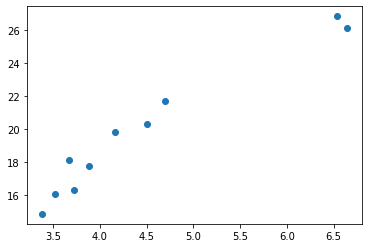

In [14]:
sample_size = 10
X = np.random.uniform(0, 10, sample_size)
X = X[:,np.newaxis]
y = 3*X + 7 + np.random.normal(0, 1, [sample_size, 1])
plt.scatter(X, y)

In [15]:
batch = Batch_gd()
sto = Stochastic_gd()
norm = Normal_eq()

In [16]:
sample_size = 1000
X = np.random.uniform(0, 10, sample_size)
X = X[:,np.newaxis]
y = 3*X + 7 + np.random.normal(0, 1, [sample_size, 1])

In [17]:
%timeit batch.learn(X, y)
%timeit sto.learn(X, y)
%timeit norm.solve(X, y)

1 loop, best of 5: 734 ms per loop


1 loop, best of 5: 750 ms per loop
The slowest run took 198.66 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 49.2 µs per loop


Normal equation provides the shortest computation time for small dataset. For small sample size, the execution time is shorter for batch gradient descent. This is because the sampling process for stochastic gradient takes longer than algebraically computing gradient for entire samples for batch gradient descent.

In [18]:
sample_size = 10**5
X = np.random.uniform(0, 10, sample_size)
X = X[:,np.newaxis]
y = 3*X + 7 + np.random.normal(0, 1, [sample_size, 1])

In [19]:
%time batch.learn(X, y)
%time sto.learn(X, y)
%time norm.solve(X, y)

Wall time: 1min 11s


Wall time: 1.18 s
Wall time: 3.99 ms


array([[6.99868945],
       [3.00109605]])

As the sample size grows, stochastic algorithm becomes much faster than batch algorithm. For the dataset with only one feature type (dm = k x 1), normal equation is still faster than iterative algorithms.

### 2D visualisation

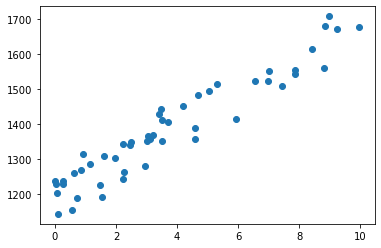

In [32]:
sample_size = 50
X = np.random.uniform(0, 10, sample_size)
X = X[:,np.newaxis]
y = 49*X + 1204 + np.random.normal(0, 50, [sample_size, 1])
plt.scatter(X, y)

In [33]:
batch = Batch_gd()
batch.lr = 0.002
sto = Stochastic_gd()
sto.lr = 0.002
norm = Normal_eq()

In [34]:
batch_theta, batch_cost = batch.learn_cost(X, y)
sto_theta, sto_cost = sto.learn_cost(X, y)

In [35]:
x_domain = np.arange(0, 10, 0.01)[:,np.newaxis]
batch_pred = batch.predict(x_domain)
sto_pred = sto.predict(x_domain)

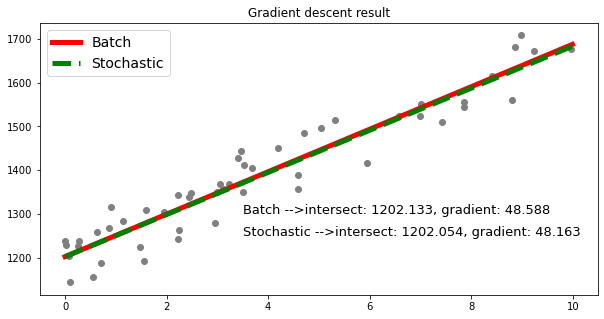

In [36]:
plt.figure(figsize=(10, 5))
plt.scatter(X, y, color = 'grey')
plt.plot(x_domain, batch_pred, color = 'red', lw = 5, label = 'Batch')
plt.plot(x_domain, sto_pred, '--', color = 'green', lw = 5, label = 'Stochastic')
plt.text(3.5, 1300, 'Batch -->intersect: %.3f, gradient: %.3f' %(batch_theta[-1][0], batch_theta[-1][1]), fontsize = 13)
plt.text(3.5, 1250, 'Stochastic -->intersect: %.3f, gradient: %.3f' %(sto_theta[-1][0], sto_theta[-1][1]), fontsize = 13)
plt.title('Gradient descent result')
plt.legend(fontsize = 14)

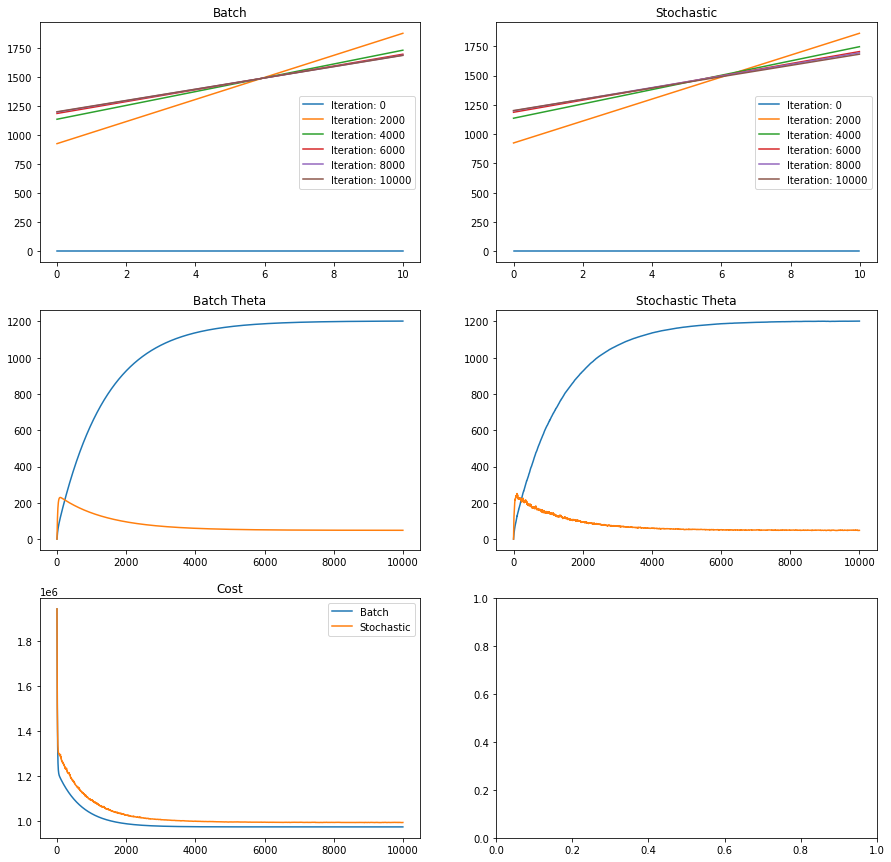

In [42]:
fig, ax = plt.subplots(3,2, figsize =(15, 15))
for i in range(0, 10001, 2000):
    ax[0,0].plot(x_domain, batch_theta[i][0]+(batch_theta[i][1]*x_domain), label = 'Iteration: %d' %i)
    ax[0,1].plot(x_domain, sto_theta[i][0]+(sto_theta[i][1]*x_domain), label = 'Iteration: %d' %i)
ax[0,0].set_title('Batch')
ax[0,0].legend()
ax[0,1].set_title('Stochastic')
ax[0,1].legend()
ax[1, 0].plot(batch_theta[:,0], label = 'Intersect')
ax[1, 0].plot(batch_theta[:,1], label = 'Gradient')
ax[1, 0].set_title('Batch Theta')
ax[1, 1].plot(sto_theta[:,0], label = 'Intersect')
ax[1, 1].plot(sto_theta[:,1], label = 'Gradient')
ax[1, 1].set_title('Stochastic Theta')
ax[2, 0].plot(batch_cost, label = 'Batch')
ax[2, 0].plot(sto_cost, label = 'Stochastic')
ax[2, 0].set_title('Cost')
ax[2, 0].legend()

### 3d visualisation

In [43]:
batch_theta[-1]

array([1202.13282629,   48.58819369])